<a href="https://www.kaggle.com/code/melihkotman/network-anomaly-detection-isolation-forest?scriptVersionId=298814550" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Network Anomaly Detection: Isolation Forest

Bu projede, denetimsiz öğrenme (Unsupervised Learning) kullanarak ağ trafiği içindeki siber saldırıları ve anormallikleri tespit edeceğiz.

Geleneksel güvenlik duvarları (Firewall) kurallara göre çalışır. Ancak biz burada **Isolation Forest** algoritmasını kullanarak, daha önce hiç tanımlanmamış saldırı desenlerini (Zero-Day Attacks) matematiksel sapmalar üzerinden yakalamayı hedefliyoruz.

###  Methods:
* **Algorithm:** Isolation Forest (Anormallik Tespiti)
* **Dataset:** Network Intrusion Dataset (TCP/IP Akış Verileri)
* **Goal:** Etiketleri kullanmadan (Unsupervised) saldırgan trafiği normal trafikten ayırmak.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Anormallik Tespiti için Yıldız Oyuncumuz
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Görselleştirme için
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Optimization and Data Engineering
import os

df_list = []

# We are visiting all csv files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            file_path = os.path.join(dirname, filename)
            print(f"Reading and Sampling: {filename}")
            
            # Reading file (IDS verilerindeki tip uyuşmazlığı uyarılarını gizlemek için low_memory=False)
            temp_df = pd.read_csv(file_path, low_memory=False)
            
            # Taking %10 sample for each csv files
            temp_df = temp_df.sample(frac=0.1, random_state=42) 
            
            df_list.append(temp_df)

# Making each csv sample's in same pot.
df = pd.concat(df_list, axis=0, ignore_index=True)

# Cleaning trash features
df.columns = df.columns.str.strip()

print(f"\nData Concatenation!")
print(f"Rows and Columns Count: {df.shape}")
display(df.head())


print(df.head())
print(df.info())

Reading and Sampling: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading and Sampling: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading and Sampling: Tuesday-WorkingHours.pcap_ISCX.csv
Reading and Sampling: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading and Sampling: Monday-WorkingHours.pcap_ISCX.csv
Reading and Sampling: Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading and Sampling: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading and Sampling: Wednesday-workingHours.pcap_ISCX.csv

Data Concatenation!
Rows and Columns Count: (283074, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,77689,4,8,6134,153,4686,0,1533.5,2209.736862,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,3659078,10,9,717,5821,363,0,71.7,121.708258,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,44176,76,1,1,2,6,2,2,2.0,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
3,8641,81,1,1,6,6,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,1026,61,1,1,2,6,2,2,2.0,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan


   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0                80          77689                  4                       8   
1               443        3659078                 10                       9   
2             44176             76                  1                       1   
3              8641             81                  1                       1   
4              1026             61                  1                       1   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         6134                          153   
1                          717                         5821   
2                            2                            6   
3                            6                            6   
4                            2                            6   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                   4686                      0            

In [2]:
## Data Cleaning and Preprocessing 

In [3]:
# Null and Infinity Values Cleaning
# If packet time is 0, speed of packet can be inf.
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df.dropna(inplace=True)

print(f"After Cleaning Remaining Rows: {df.shape[0]}")

# X (Features) and y (Real Labels) Splitting
X = df.drop(columns=['Label'])
y_true = df['Label']

#Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nDatas preprocessed and Ready for Isolation Forest")

After Cleaning Remaining Rows: 282788

Datas preprocessed and Ready for Isolation Forest


## Threat Hunting with Isolation Forest (Test 1: %15 Contamination)

In [21]:
# Modelling
# Contamination: Percentage of harmful network traffic
iso_forest = IsolationForest(n_estimators=100, contamination=0.15,random_state =42)

# Model Training
print("Isolation Forest Training...")
iso_forest.fit(X_scaled)

# Prediction
predictions = iso_forest.predict(X_scaled)

df['Anomaly_Score'] = iso_forest.decision_function(X_scaled) # Each packet suspicious rate
df['Prediction'] = predictions
df['Prediction_Label'] = df['Prediction'].map({1: 'Normal', -1: 'Anomaly'})

print("\n Threat Hunting is Completed... Machine Prediction Rates")
print(df['Prediction_Label'].value_counts())

Isolation Forest Training...

 Threat Hunting is Completed... Machine Prediction Rates
Prediction_Label
Normal     240369
Anomaly     42419
Name: count, dtype: int64


## Evaulation: Isolation Forest (%15) Confusion Matrix 

--- Isolation Forest Results ---
              precision    recall  f1-score   support

     Anomaly       0.51      0.39      0.44     55686
      Normal       0.86      0.91      0.88    227102

    accuracy                           0.81    282788
   macro avg       0.68      0.65      0.66    282788
weighted avg       0.79      0.81      0.79    282788



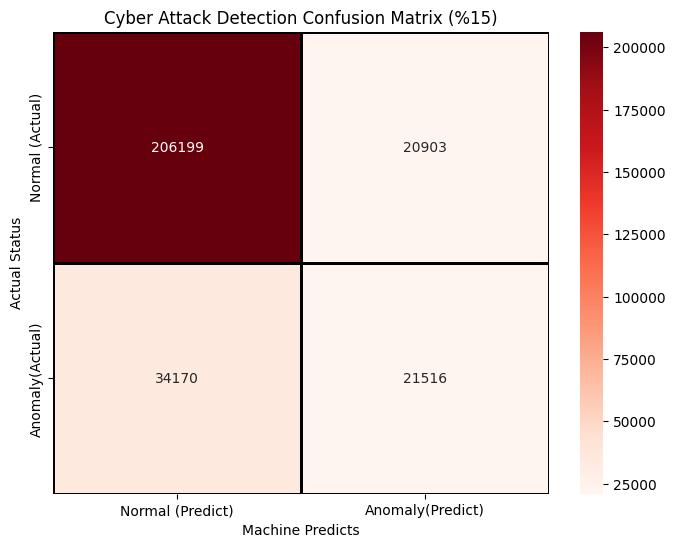

In [22]:
# Real Label should be binary
df['True_Label'] = df['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Anomaly')

# Classification Report
print("--- Isolation Forest Results ---")
print(classification_report(df['True_Label'], df['Prediction_Label']))

# Confusion Matrix Visualization 
cm = confusion_matrix(df['True_Label'], df['Prediction_Label'], labels = ['Normal', 'Anomaly'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Reds',
    linewidths=1,
    linecolor='black',
    xticklabels=['Normal (Predict)', 'Anomaly(Predict)'],
    yticklabels=['Normal (Actual)', 'Anomaly(Actual)']
)
plt.title('Cyber Attack Detection Confusion Matrix (%15)')
plt.ylabel('Actual Status')
plt.xlabel('Machine Predicts')
plt.show()

## EDA and PCA Visualization (%15)

Data Reduces 2 Dimensional, Please Wait!


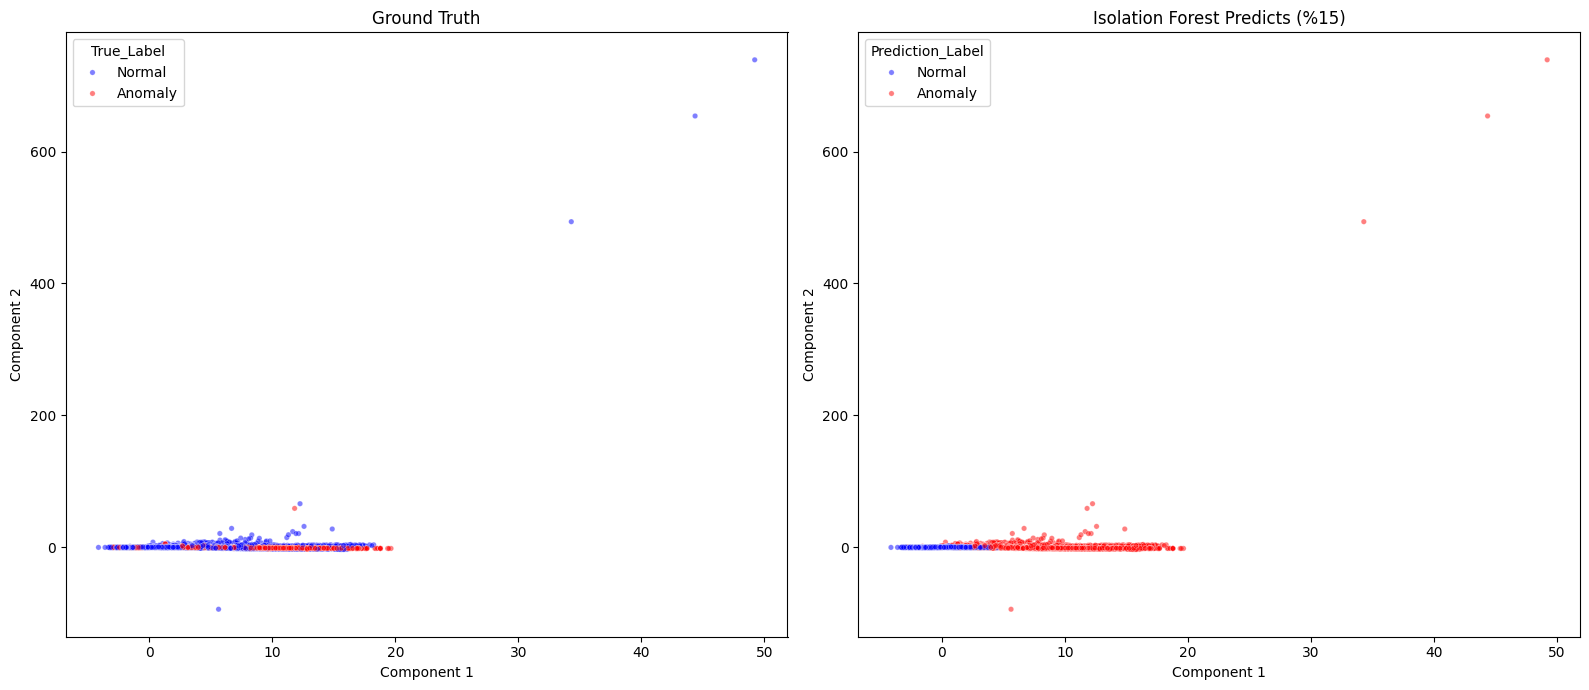

In [23]:
# Step of PCA
print("Data Reduces 2 Dimensional, Please Wait!")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# PCA datas added to DataFrame
df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['True_Label'] = df['True_Label'].values
df_pca['Prediction_Label'] = df['Prediction_Label'].values

# Random 50.000 row selected for matplotlib
df_pca_sample = df_pca.sample(n=50000, random_state = 42)

# Visualization
fig, axes = plt.subplots(1, 2,figsize=(16, 7))

# Actual Status
sns.scatterplot(
    ax=axes[0], x='PCA1', y='PCA2', hue ='True_Label',
    data=df_pca_sample, palette={'Normal': 'blue', 'Anomaly': 'red'},
    s=15, alpha=0.5
)
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')
# Machine Prediction Status
sns.scatterplot(
    ax=axes[1], x='PCA1', y='PCA2', hue ='Prediction_Label',
    data=df_pca_sample, palette={'Normal': 'blue', 'Anomaly': 'red'},
    s=15, alpha=0.5
)
axes[1].set_title('Isolation Forest Predicts (%15)')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')

plt.tight_layout()
plt.show()

## Test 1 Results and Analysis

Bu projede ağ trafiği üzerindeki anormallikleri tespit etmek için denetimsiz bir öğrenme modeli olan **Isolation Forest** kullandık. Elde ettiğimiz metrikler ve PCA görselleştirmesi, siber güvenlikte Unsupervised Learning'in (Denetimsiz Öğrenme) sınırlarını çarpıcı bir şekilde ortaya koymuştur:

### First Test Results ve EDA Analysis
1. **Masking Problem:** Gerçek etiketleri (Ground Truth) incelediğimizde, saldırıların (özellikle PortScan/DDoS) uzak noktalarda (Outlier) değil, aksine kendi içlerinde çok yoğun ve sıkı kümeler oluşturduğunu gördük. Isolation Forest, anormalliklerin "seyrek" olduğunu varsaydığı için bu yoğun saldırı dalgalarını "Normal Trafik" zannederek gözden kaçırmıştır (Düşük Recall: %39).
2. **False Positive Bombing:** Modele verdiğimiz `%15 contamination` (beklenen kirlilik) oranı, modelin bu kotayı doldurmak için agresifleşmesine neden olmuştur. Gerçek saldırıları kaçıran model, kotayı doldurmak adına ana normal kümenin etrafındaki hafif sapan masum paketleri de anomali olarak işaretlemiştir.
3. **Overlapping:** PCA haritasında normal ve zararlı paketlerin X ekseni boyunca iç içe geçtiği (Overlapping) görülmektedir.


## Test 2: %20 Contamination

In [26]:
# Modelling
# Contamination: Percentage of harmful network traffic
iso_forest_second = IsolationForest(n_estimators=100, contamination=0.04,random_state =42)

# Model Training
print("Isolation Forest Training...")
iso_forest_second.fit(X_scaled)

# Prediction
predictions = iso_forest_second.predict(X_scaled)

df['Anomaly_Score2'] = iso_forest_second.decision_function(X_scaled) # Each packet suspicious rate
df['Prediction2'] = predictions
df['Prediction_Label2'] = df['Prediction2'].map({1: 'Normal', -1: 'Anomaly'})

print("\n Threat Hunting is Completed... Machine Prediction Rates")
print(df['Prediction_Label2'].value_counts())

Isolation Forest Training...

 Threat Hunting is Completed... Machine Prediction Rates
Prediction_Label2
Normal     271476
Anomaly     11312
Name: count, dtype: int64


--- Isolation Forest Results ---
              precision    recall  f1-score   support

     Anomaly       0.31      0.06      0.11     55686
      Normal       0.81      0.97      0.88    227102

    accuracy                           0.79    282788
   macro avg       0.56      0.51      0.49    282788
weighted avg       0.71      0.79      0.73    282788



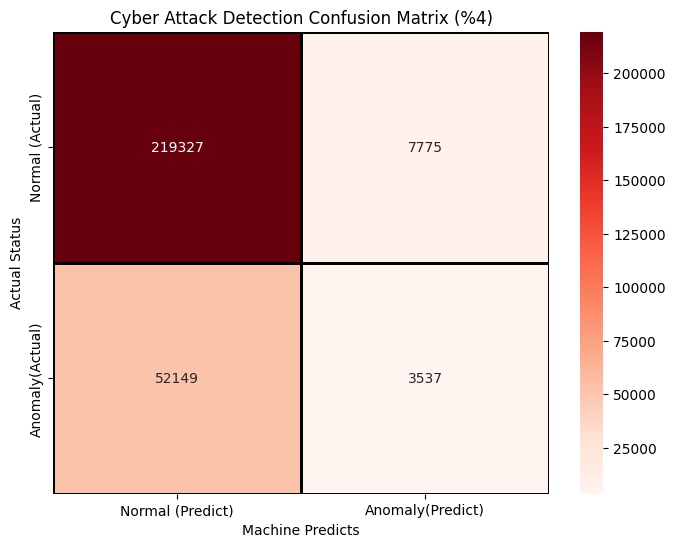

In [27]:
# Real Label should be binary
df['True_Label2'] = df['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Anomaly')

# Classification Report
print("--- Isolation Forest Results ---")
print(classification_report(df['True_Label2'], df['Prediction_Label2']))

# Confusion Matrix Visualization 
cm = confusion_matrix(df['True_Label2'], df['Prediction_Label2'], labels = ['Normal', 'Anomaly'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Reds',
    linewidths=1,
    linecolor='black',
    xticklabels=['Normal (Predict)', 'Anomaly(Predict)'],
    yticklabels=['Normal (Actual)', 'Anomaly(Actual)']
)
plt.title('Cyber Attack Detection Confusion Matrix (%4)')
plt.ylabel('Actual Status')
plt.xlabel('Machine Predicts')
plt.show()

## Test 3: %20 Contamination

Isolation Forest Training...

 Threat Hunting is Completed... Machine Prediction Rates
Prediction_Label2
Normal     226230
Anomaly     56558
Name: count, dtype: int64
--- Isolation Forest Results ---
              precision    recall  f1-score   support

     Anomaly       0.44      0.44      0.44     55686
      Normal       0.86      0.86      0.86    227102

    accuracy                           0.78    282788
   macro avg       0.65      0.65      0.65    282788
weighted avg       0.78      0.78      0.78    282788



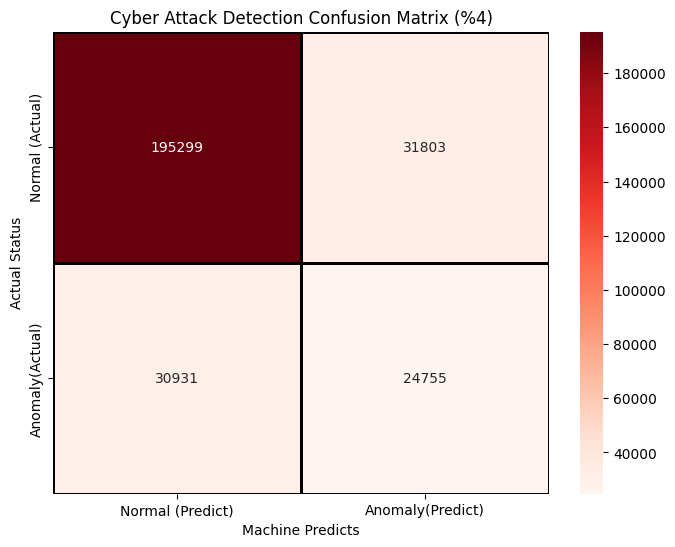

In [29]:
# Modelling
# Contamination: Percentage of harmful network traffic
iso_forest_second = IsolationForest(n_estimators=100, contamination=0.20,random_state =42)

# Model Training
print("Isolation Forest Training...")
iso_forest_second.fit(X_scaled)

# Prediction
predictions = iso_forest_second.predict(X_scaled)

df['Anomaly_Score2'] = iso_forest_second.decision_function(X_scaled) # Each packet suspicious rate
df['Prediction2'] = predictions
df['Prediction_Label2'] = df['Prediction2'].map({1: 'Normal', -1: 'Anomaly'})

print("\n Threat Hunting is Completed... Machine Prediction Rates")
print(df['Prediction_Label2'].value_counts())

# Real Label should be binary
df['True_Label2'] = df['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Anomaly')

# Classification Report
print("--- Isolation Forest Results ---")
print(classification_report(df['True_Label2'], df['Prediction_Label2']))

# Confusion Matrix Visualization 
cm = confusion_matrix(df['True_Label2'], df['Prediction_Label2'], labels = ['Normal', 'Anomaly'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Reds',
    linewidths=1,
    linecolor='black',
    xticklabels=['Normal (Predict)', 'Anomaly(Predict)'],
    yticklabels=['Normal (Actual)', 'Anomaly(Actual)']
)
plt.title('Cyber Attack Detection Confusion Matrix (%4)')
plt.ylabel('Actual Status')
plt.xlabel('Machine Predicts')
plt.show()

## Hyperparameter Results and Business Insights

Bu son bölümde, tehditleri yakalamak ile yanlış alarmları (False Positive) önlemek arasındaki en uygun dengeyi bulmak için Isolation Forest algoritmasının `contamination` (kirlilik/beklenen anomali oranı) parametresi üzerinde bir A/B testi gerçekleştirdik. Üç farklı senaryoyu test ettik: %4, %15 ve %20.

### Tests Results

* **Contamination = 0.04 ("Eksik Öğrenme / Underfitting" Senaryosu):** * **Sonuç:** Recall (Duyarlılık) **0.06**'ya çakılırken, Accuracy (Doğruluk) 0.79'a düştü. 
  * **İçgörü:** Model aşırı pasif hale geldi. Sadece en uçtaki anormallikleri yakalayabildi ancak devasa DDoS ve PortScan saldırı kümelerini tamamen gözden kaçırdı. Gerçek dünya senaryosunda bu durum, ağı son derece savunmasız bırakır.

* **Contamination = 0.15 ("Dengeli" Temel Senaryo):** * **Sonuç:** **0.79** Ağırlıklı F1-Skoru (Weighted F1-Score) ve **0.81** Doğruluk (Accuracy) ile en stabil duruma ulaştı. 
  * **İçgörü:** Bu oran, bu spesifik algoritma için "en ideal nokta" (sweet spot) oldu. Yanlış Alarm oranını yönetilebilir bir seviyede tutarken (Precision: 0.51), anormalliklerin önemli bir kısmını (Recall: 0.39) yakalamayı başardı.

* **Contamination = 0.20 ("Paranoyak" Senaryo):** * **Sonuç:** Recall 0.44'e yükseldi, ancak Precision (Kesinlik) keskin bir düşüşle **0.44**'e geriledi ve genel Accuracy'yi 0.78'e düşürdü.
  * **İçgörü:** Modeli daha fazla anomali bulmaya zorlamak, onu aşırı agresif hale getirdi. %20'lik kotayı doldurmak için yasal (Normal) ağ paketlerini de tehdit olarak etiketlemeye başladı ve bu da Yanlış Alarmlarda (False Positives) devasa bir artışa yol açtı.

### SOC Analyst Perspective

%20 contamination modelini canlı bir Güvenlik Operasyonları Merkezinde (SOC) devreye almak, siber güvenlikte **Alarm Yorgunluğu (Alert Fatigue)** olarak bilinen kritik bir soruna yol açacaktır. Eğer güvenlik alarmlarının yarısından fazlası Yanlış Alarm ise (0.44 Precision skorunda görüldüğü gibi), güvenlik analistleri bir süre sonra sistemi görmezden gelmeye başlayacak ve gerçek tehditlerin fark edilmeden sızmasına neden olacaktır.

### Final Verdict and Future Work

Bu deney Veri Biliminin temel bir kuralını kanıtlamıştır: *Eğer bir algoritmanın temel varsayımı (örn. "anormallikler seyrektir"), verinin doğasıyla ("DDoS saldırıları yoğun ve devasa kümeler oluşturur") çelişiyorsa, hiperparametre optimizasyonu tek başına sorunu çözemez.*

**Next Steps:** Denetimsiz Öğrenme (Isolation Forest) sıfırıncı gün (zero-day/bilinmeyen) anormallikleri bulmakta mükemmel olsa da, yoğun saldırı desenlerinde zorlanmaktadır. >%99 tespit oranlarına ulaşmak için bu problem, sistemin hem Normal hem de Zararlı trafiğin kesin matematiksel imzalarını öğrendiği **Denetimli Öğrenme (Supervised Learning)** algoritmaları (Random Forest veya XGBoost gibi) kullanılarak modellenmelidir.